<a href="https://colab.research.google.com/github/Leetora41053/sesac_practice/blob/main/11_27_Convolutional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import SGD

In [ ]:
'''원본'''

class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
    self.conv1_act = nn.Tanh()
    self.avg1 = nn.AvgPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
    self.conv2_act = nn.Tanh()
    self.avg2 = nn.AvgPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
    self.conv3_act = nn.Tanh()

    self.fc1 = nn.Linear(in_features=120, out_features=84)
    self.fc2 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv1_act(x)
    x = self.avg1(x)

    x = self.conv2(x)
    x = self.conv2_act(x)
    x = self.avg2(x)

    x = self.conv3(x)
    x = self.conv3_act(x)#(B, 120, 1, 1)-> (120, B*1*1)
    x = x.view(x.shape[0], -1)

    x = self.fc1(x) # in_features: 채널 수 * 행 * 열
    x = self.fc2(x)
    #Cross Entropy의 loss_function에서 해주기 때문에 괜찮다
    return x

a = LeNet
#모델링 후 randn으로 input shape를 만들고 레이어를 통과할 때마다 torch shape를 뽑아낸다
#input tensor를 해서 스스로 맞는지 검증까지 거친다

In [ ]:
'''nn.Seqeuntial'''

class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
        nn.Tanh()
        )

    self.layer2 = nn.Sequential(
        nn.Linear(in_features=120, out_features=84),
        nn.Linear(84, 10))

  def forward(self, x):
    x = self.layer1(x)
    x = x.view(x.shape[0], -1)
    x = self.layer2(x)
    return x

#모델링 후 randn으로 input shape를 만들고 레이어를 통과할 때마다 torch shape를 뽑아낸다
#input tensor를 해서 스스로 맞는지 검증까지 거친다

In [ ]:

'''Model Testing'''

#BCHW 순서
test1 = torch.randn((10, 1, 28, 28))

model = LeNet()

out1 = model.forward(test1)

out1.shape


torch.Size([10, 10])

In [ ]:


'''MNIST'''

dataset = MNIST(root='data', train=True, download=True)

for img, label in dataset:
  print(type(img))
  print(type(label))
  img = np.array(img)

  print(img.shape, img.dtype)
  break

<class 'PIL.Image.Image'>
<class 'int'>
(28, 28) uint8


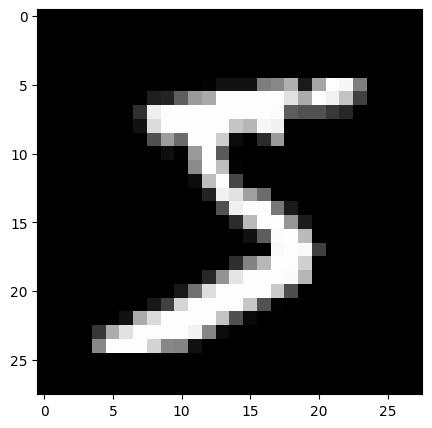

In [ ]:
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

dataset = MNIST(root='data', train=True, download=True)

fig, ax = plt.subplots(figsize=(5, 5))

for img, label in dataset:
    ax.imshow(img, cmap='gray')
    break

In [ ]:
BATCH_SIZE = 28

dataset = MNIST(root='data', train=True, download=True, transform=ToTensor())
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
n_sample = len(dataset)

print(n_sample) #데이터에 들어가는 전체 샘플의 개수

60000


In [ ]:
LR = 0.003
EPOCHS = 10

if torch.cuda.is_available(): DEVICE = 'cuda'
elif torch.backends.mps.is_available(): DEVICE = 'mps'
else: DEVICE = 'cpu'

model = LeNet().to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LR)

losses, accs = [], []
for epoch in range(EPOCHS):
    epoch_loss, n_corrects = 0., 0
    for X_, y_ in tqdm(dataloader):
        X_, y_ = X_.to(DEVICE), y_.to(DEVICE)
        # X_ = X_.reshape(BATCH_SIZE, -1) #Linear 선형 모델에서는 일자로 맞춰줘야 하지만 CNN은 넣기만 하면 알아서 계산해줌

        pred = model(X_)
        loss = loss_function(pred, y_)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * len(X_)
        n_corrects += (torch.max(pred, axis=1)[1] == y_).sum().item()

    epoch_loss /= n_sample
    losses.append(epoch_loss)

    epoch_acc = n_corrects / n_sample
    accs.append(epoch_acc)

    print(f"Epoch: {epoch + 1}")
    print(f"Loss: {epoch_loss: .4f}, Acc: {epoch_acc: .4f}")

## nn.Sequential

100%|██████████| 2143/2143 [00:32<00:00, 66.14it/s]


Epoch: 1
Loss:  2.0794, Acc:  0.3771


100%|██████████| 2143/2143 [00:34<00:00, 62.31it/s]


Epoch: 2
Loss:  0.8099, Acc:  0.7732


100%|██████████| 2143/2143 [00:31<00:00, 67.14it/s]


Epoch: 3
Loss:  0.4569, Acc:  0.8698


100%|██████████| 2143/2143 [00:34<00:00, 61.62it/s]


Epoch: 4
Loss:  0.3677, Acc:  0.8930


100%|██████████| 2143/2143 [00:33<00:00, 63.67it/s]


Epoch: 5
Loss:  0.3215, Acc:  0.9056


100%|██████████| 2143/2143 [00:33<00:00, 64.57it/s]


Epoch: 6
Loss:  0.2874, Acc:  0.9152


100%|██████████| 2143/2143 [00:37<00:00, 57.32it/s]


Epoch: 7
Loss:  0.2589, Acc:  0.9232


100%|██████████| 2143/2143 [00:32<00:00, 65.97it/s]


Epoch: 8
Loss:  0.2343, Acc:  0.9300


100%|██████████| 2143/2143 [00:31<00:00, 67.88it/s]


Epoch: 9
Loss:  0.2131, Acc:  0.9364


100%|██████████| 2143/2143 [00:34<00:00, 62.55it/s]

Epoch: 10
Loss:  0.1947, Acc:  0.9419


# VGG Model

In [ ]:
H, W = 224, 224
input_tensor = torch.randn(size=(8, 3, H, W))

class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(),

            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),

            nn.Linear(in_features=4096, out_features=1000))

    def forward(self, x):
        x = self.feature(x)
        # (b, c, h, w)
      # torch.view(1차원, 2차원)
        x = x.view(x.size(0), -1)
      # mlp (b, w) -> (b, 512*7*7)
        x = self.classifier(x)
        #Cross Entropy의 loss_function에서 해주기 때문에 softmax가 없어도 괜찮음
        return x


model = VGGNet()
model.forward(input_tensor)


#모델링 후 randn으로 input shape를 만들고 레이어를 통과할 때마다 torch shape를 뽑아낸다
#input tensor를 해서 스스로 맞는지 검증까지 거친다

tensor([[-0.0090,  0.0099,  0.0073,  ..., -0.0044,  0.0108,  0.0137],
        [-0.0090,  0.0099,  0.0073,  ..., -0.0044,  0.0107,  0.0137],
        [-0.0090,  0.0099,  0.0073,  ..., -0.0044,  0.0107,  0.0137],
        ...,
        [-0.0091,  0.0099,  0.0073,  ..., -0.0044,  0.0107,  0.0137],
        [-0.0090,  0.0099,  0.0073,  ..., -0.0044,  0.0107,  0.0137],
        [-0.0090,  0.0099,  0.0073,  ..., -0.0044,  0.0107,  0.0137]],
       grad_fn=<AddmmBackward0>)